## Notebook escrito en Visualizar 2017
Medialab Prado 2017

proyecto mobilomics ( martin@muimota.net )
carga un dump de paradas de EMT durante 20 Sep 2017 y hace distintas visualizaciones

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
df = pd.read_csv('demanda_fixed.csv.gz',sep =';',compression='gzip')
#termina con unas lineas de log que hay que quitar
df = df.dropna()
df['instante'] = pd.to_datetime(df['instante'])
#limpiamos datos que no sean del 20 - 9 -2017
df = df[(df['instante'] > '2017-09-20') & (df['instante'] < '2017-09-21')]
del df['FECHA']

/Users/muimota/anaconda/envs/dato-env/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
df.head()

linea cochelogico  parada            instante  viajeros  \
0     1           1     718 2017-09-20 06:31:13         1   
1     1           1     722 2017-09-20 06:32:26         1   
2     1           1     722 2017-09-20 06:32:28         1   
3     1           1    2307 2017-09-20 06:34:11         1   
4     1           1     451 2017-09-20 06:43:16         1   

                  nombre   latitude  longitude  
0              CARTAGENA  40.439570  -3.673786  
1        CARTAGENA-BEJAR  40.437135  -3.671116  
2        CARTAGENA-BEJAR  40.437135  -3.671116  
3  PLAZA DE SAN CAYETANO  40.433904  -3.670554  
4          METRO SERRANO  40.426055  -3.687923

In [4]:
#lineas con mas paradas
lineas_paradas = df[['linea','parada']].drop_duplicates().groupby('linea').count().sort('parada',ascending = False)
lineas_paradas.head()

parada
linea        
150        91
116        88
132        82
71         81
34         80

# Rutas de Bus

In [5]:
#devuelve 
def buslog(linea,cochelogico,coordinates = False):
    
    bus_ruta = df[(df['linea'] == linea) & (df['cochelogico'] == cochelogico)].sort('instante')
    parada = -1
    instante        = []
    paradas         = []
    viajeros_parada = []
    instantes       = []
    viajeros        = 0
    for index, row in bus_ruta.iterrows():
        if parada != row['parada']:
            #print parada,viajeros
            if parada != -1:
                viajeros_parada.append(viajeros)
                paradas.append(parada)
                instantes.append(row['instante'])
            viajeros = 0
            parada = int(row['parada'])
            
        viajeros += int(row['viajeros'])
    
    ruta = pd.DataFrame(zip(paradas,viajeros_parada,instantes),columns=('parada','viajeros','instante'))
    
    
    if coordinates:
    
        nombres_paradas = df[['parada','nombre','latitude','longitude']].drop_duplicates().set_index('parada')
        ruta = ruta.set_index('parada').join(nombres_paradas)
        
    ruta = ruta.set_index('instante').sort()
        
    return ruta

In [6]:
buslog(2,3).head()

parada  viajeros
instante                             
2017-09-20 06:31:12     186         1
2017-09-20 06:32:16     187         1
2017-09-20 06:35:21     188         1
2017-09-20 06:37:19     190         8
2017-09-20 06:39:29     192         1

In [7]:
buslog(2,3,True).head()

viajeros                                  nombre  \
instante                                                                
2017-09-20 06:31:12         1                          REINA VICTORIA   
2017-09-20 06:32:16         1  GUZMAN EL BUENO-SAN FRANCISCO DE SALES   
2017-09-20 06:35:21         1                              JUAN VIGON   
2017-09-20 06:37:19         8   GUZMAN EL BUENO-FERNANDEZ DE LOS RIOS   
2017-09-20 06:39:29         1                               ARGUELLES   

                      latitude  longitude  
instante                                   
2017-09-20 06:31:12  40.445816  -3.712419  
2017-09-20 06:32:16  40.442869  -3.712660  
2017-09-20 06:35:21  40.441543  -3.712830  
2017-09-20 06:37:19  40.435811  -3.713238  
2017-09-20 06:39:29  40.430962  -3.713626

## dibujamos linea 44 coche 1 
De 6:00 a 10:30

In [8]:
import folium
#linea 2, coche 5
ruta = buslog(44,1,True)
#filtramos de 9 a 11
ruta = ruta.between_time('6:00','10:30')

center = ruta[['latitude','longitude']].mean()
m = folium.Map(location=[center[0], center[1]],zoom_start=13)
folium.PolyLine(ruta[['latitude','longitude']].values.tolist()).add_to(m)
m

# viajeros paradas

analizamos el número total de los viajeros 

In [9]:
#viajeros paradas
bus_time = df.set_index('instante').between_time('6:00','10:00')
viajeros_parada = bus_time.groupby('parada')[['viajeros']].sum().sort('viajeros',ascending=False)
viajeros_parada.head()

viajeros
parada          
1401        2093
3688        1859
4247        1618
2994        1480
1687        1375

In [10]:
#join con las coordenadas
viajeros_parada = viajeros_parada.join(df[['parada','latitude','longitude']].drop_duplicates().set_index('parada'))
viajeros_parada.head()

viajeros   latitude  longitude
parada                                
1401        2093  40.406642  -3.689101
3688        1859  40.434219  -3.718718
4247        1618  40.438421  -3.676200
2994        1480  40.501366  -3.682420
1687        1375  40.443473  -3.726977

In [11]:
viajeros_parada['viajeros_norm'] = viajeros_parada['viajeros']/viajeros_parada.max()['viajeros']
viajeros_parada.head()

viajeros   latitude  longitude  viajeros_norm
parada                                               
1401        2093  40.406642  -3.689101       1.000000
3688        1859  40.434219  -3.718718       0.888199
4247        1618  40.438421  -3.676200       0.773053
2994        1480  40.501366  -3.682420       0.707119
1687        1375  40.443473  -3.726977       0.656952

# Timeline

In [12]:
densidadDia = []

#viajeros paradas
for hour in range(23):
    bus_time = df.set_index('instante').between_time("{:02d}:00".format(hour),"{:02d}:00".format((hour + 1) % 24))
    viajeros_parada = bus_time.groupby('parada')[['viajeros']].sum().sort('viajeros',ascending=False)
    #join con las coordenadas
    viajeros_parada = viajeros_parada.join(df[['parada','latitude','longitude']].drop_duplicates().set_index('parada'))
    #normalizacion
    viajeros_parada['viajeros_norm'] = viajeros_parada['viajeros']/viajeros_parada.max()['viajeros']
    
    densidadDia.append(viajeros_parada[['latitude','longitude','viajeros_norm']].values.tolist())

# mapa con linea de tiempo 
Muestra las paradas donde se suben mas pasajeros.

In [13]:
from folium.plugins import HeatMapWithTime

center = viajeros_parada[['latitude','longitude']].mean()
m = folium.Map(location=[center[0], center[1]],zoom_start=11)
HeatMapWithTime(data = densidadDia).add_to(m)
m

Podemos salvar en un html

In [14]:
#save as html
#m.save('../../vis/04_EMT_densidad/index.html')

# Preguntas

## paradas con mayor volumen de viajeros

In [15]:
#viajeros paradas
bus_time = df.set_index('instante')
viajeros_parada = bus_time.groupby('parada')[['viajeros']].sum().sort('viajeros',ascending=False)
#join con las coordenadas
viajeros_parada = viajeros_parada.join(df[['parada','nombre','latitude','longitude']].drop_duplicates().set_index('parada'))

In [16]:
from folium.plugins import HeatMap

#numero de estaciones en el heatmap
num_estaciones = 20

center = viajeros_parada[['latitude','longitude']][:num_estaciones].mean()
m = folium.Map(location=[center[0], center[1]],zoom_start=11)
HeatMap(data = viajeros_parada[['latitude','longitude']].head(num_estaciones).values.tolist()).add_to(m)
m

# 20 estaciones mas concurridas

In [17]:
#numero de estaciones en el heatmap
num_estaciones = 20
estacion_radius = 200
viajeros_parada['viajeros_norm'] = viajeros_parada['viajeros']/viajeros_parada.max()['viajeros']
estaciones = viajeros_parada.head(num_estaciones)
center = estaciones[['latitude','longitude']].mean()


m = folium.Map(location=[center[0], center[1]],zoom_start=11)

for index,estacion in estaciones.iterrows():
   
    folium.Circle(
        radius= estacion['viajeros_norm'] * estacion_radius ,
        location=estacion[['latitude','longitude']].tolist(),
        popup       = "estación:{} <br> viajeros:{}".format(estacion['nombre'],int(estacion['viajeros'])).decode('utf8'),
        color       = 'crimson',
        fill_opacity = 1.0,
        fill        = True,
        fill_color  = 'crimson'
    ).add_to(m)
m

# Curva de asistencia

In [18]:
#https://stackoverflow.com/a/40397109/2205297
sumgrouped = df.set_index('instante').groupby([pd.TimeGrouper(freq='30min')]).agg({'viajeros':'sum','latitude':'mean'})
sumgrouped.sort('viajeros',ascending=False).head(10)

latitude  viajeros
instante                                
2017-09-20 08:30:00  40.423410     61786
2017-09-20 08:00:00  40.422620     58883
2017-09-20 14:30:00  40.423016     58733
2017-09-20 14:00:00  40.424468     57162
2017-09-20 13:00:00  40.423523     52272
2017-09-20 19:00:00  40.423542     51227
2017-09-20 07:30:00  40.422431     50778
2017-09-20 18:30:00  40.423558     50705
2017-09-20 18:00:00  40.424621     50700
2017-09-20 13:30:00  40.424297     50304

In [19]:
#convertimos timestamp a numerico para poder hacer scatter 
sumgrouped = sumgrouped.reset_index()
sumgrouped['num_instante'] = sumgrouped['instante'].dt.hour + sumgrouped['instante'].dt.minute/60
sumgrouped.sort(['instante','latitude']).head(5)

instante   latitude  viajeros  num_instante
0 2017-09-20 01:00:00  40.429121         4           1.0
1 2017-09-20 01:30:00  40.380807        47           1.5
2 2017-09-20 02:30:00  40.429452         8           2.5
3 2017-09-20 03:00:00  40.375174        52           3.0
4 2017-09-20 03:30:00  40.415575         4           3.5

In [20]:
len(sumgrouped.index)

45

# Latitud media donde se recogen los pasajeros

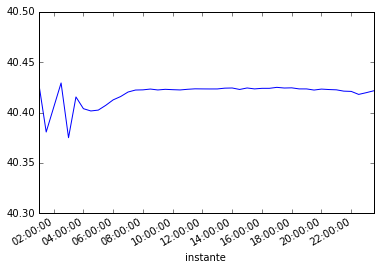

In [21]:
#está mal, la media no está ponderada por numero de pasajeros
sumgrouped.set_index('instante')['latitude'].plot(ylim=(40.3,40.5))

In [22]:
#ejemplo para poder hacer una media ponderada
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    totalItems = w.sum() # total viajeros
    
    
    return sum(d * (w/totalItems))


In [23]:
latitudes = df.set_index('instante').groupby([pd.TimeGrouper(freq='30min')]).apply(wavg,'latitude','viajeros')

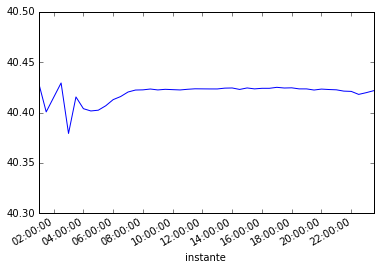

In [24]:
latitudes.plot(ylim=(40.3,40.5))